In [1]:
import os
import shutil
import glob
import cv2
import random
import operator
import pickle
from pickle import load
from tqdm import tqdm
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras
import keras.backend as K
from keras.models import load_model
from keras.constraints import max_norm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sn
import datetime

Using TensorFlow backend.


### Create DataFrames and plot data

>> Total training images:  25331   at:   /home/vasileiosaidonis/ISIC 2019/Cropped_Training_Images
>> Total test images:      8238    at:   /home/vasileiosaidonis/ISIC 2019/Test_Images



,image,age_approx,anatom_site_general,lesion_id,sex,dx,label,benign_or_malignant
5235,ISIC_0026638,50.0,lower extremity,HAM_0005929,female,NV,5,BEN
24886,ISIC_0072573,55.0,lower extremity,BCN_0003169,female,BCC,1,MAL
18041,ISIC_0061679,60.0,anterior torso,BCN_0001062,female,BKL,2,BEN
10886,ISIC_0032289,40.0,anterior torso,HAM_0001782,female,NV,5,BEN
3239,ISIC_0024642,55.0,anterior torso,HAM_0000947,female,NV,5,BEN
18919,ISIC_0063083,75.0,lower extremity,BCN_0002387,female,BCC,1,MAL
17762,ISIC_0061226,30.0,anterior torso,BCN_0000656,female,BKL,2,BEN
1822,ISIC_0013427_downsampled,65.0,upper extremity,MSK4_0010694,male,MEL,4,MAL
23719,ISIC_0070701,80.0,head/neck,BCN_0005242,male,BCC,1,MAL
24112,ISIC_0071341,45.0,anterior torso,BCN_0005101,male,NV,5,BEN


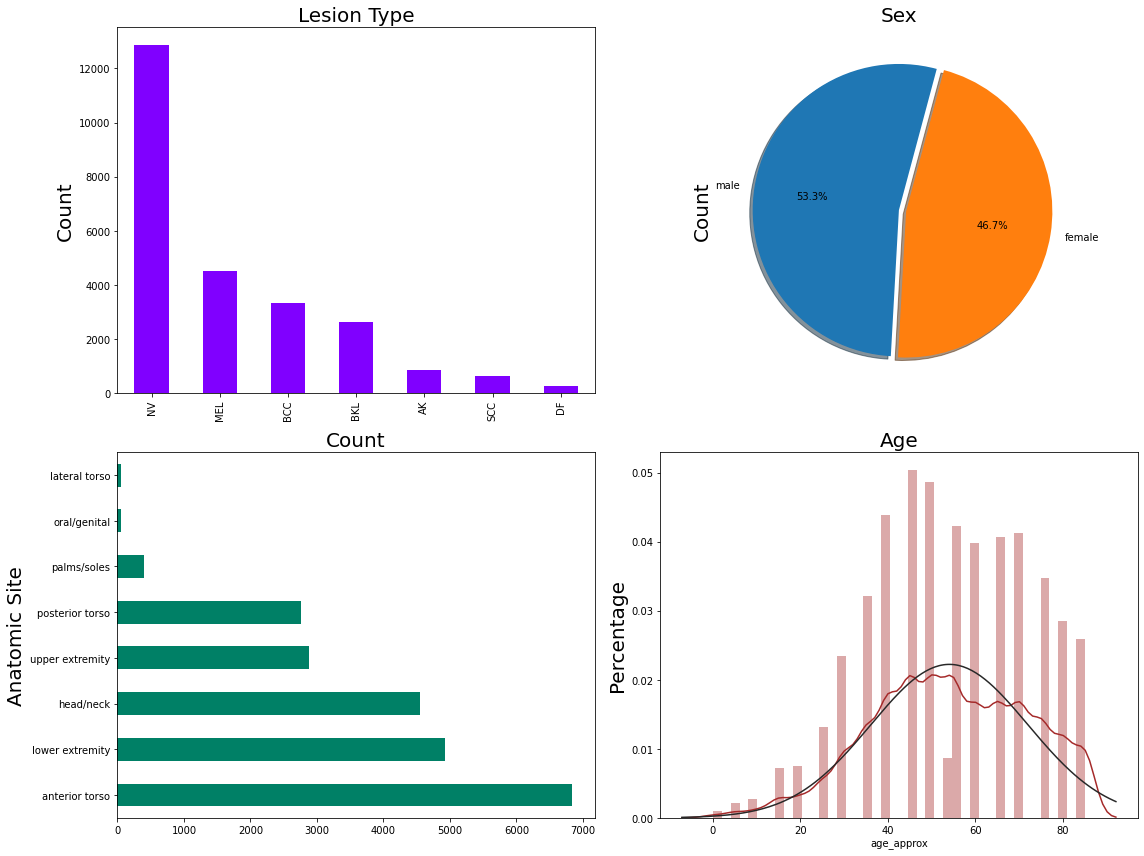

In [2]:
TRAIN_DIR = Path("/home/vasileiosaidonis/ISIC 2019/Cropped_Training_Images")
TEST_DIR = Path("/home/vasileiosaidonis/ISIC 2019/Test_Images")

num_training_images = len(os.listdir(TRAIN_DIR)) - 1   # Calculates the checkpoint 
num_test_images = len(os.listdir(TEST_DIR)) - 1

print(">> Total training images:  {}   at:   {}".format(num_training_images, TRAIN_DIR))
print(">> Total test images:      {}    at:   {}\n".format(num_test_images, TEST_DIR))

# Specify classes of benign and malignant
# benign = ['NV', 'BKL', 'DF']
# malignant = ['MEL', 'BCC', 'AK', 'SCC']

# Training csv
training_csv = pd.read_csv("/home/vasileiosaidonis/ISIC 2019/ISIC_2019_Training_Metadata.csv")
training_df = pd.DataFrame(training_csv)

# Test csv
test_csv = pd.read_csv("/home/vasileiosaidonis/ISIC 2019/ISIC_2019_Test_Metadata.csv")
test_df = pd.DataFrame(test_csv)

# Add lesion labeling from the GroundTruth csv file to the Training DataFrame 
groundtruth_csv = pd.read_csv("/home/vasileiosaidonis/ISIC 2019/ISIC_2019_Training_GroundTruth.csv")
groundtruth_df = pd.DataFrame(groundtruth_csv)
groundtruth_df["dx"] = groundtruth_df[groundtruth_df.columns[[1,2,3,4,5,6,7,8,9]]].idxmax(axis=1)
df = pd.concat([training_df, groundtruth_df["dx"]], axis=1, join='inner')
df['label'] = pd.Categorical(df['dx']).codes
df['age_approx'].fillna((df['age_approx'].mean()), inplace=True)
# Drop VASC images - AFTER CLASSIFYING IMAGES
df.drop(df['dx'][df['dx'] == "VASC"].index, axis=0, inplace=True)
df['benign_or_malignant'] = np.where(df['dx'].str.contains("NV|BKL|DF"), "BEN", "MAL")


#display(training_df.head())
display(df.sample(12))
#display(df.isnull().sum())

# Plot values of the dataset
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
df['dx'].value_counts().plot(kind='bar', ax=ax1, colormap='rainbow')
ax1.set_ylabel('Count', fontsize=20)
ax1.set_title('Lesion Type', fontsize=20);

ax2 = fig.add_subplot(222)
df['sex'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%',
                              shadow=True, startangle=75, explode=(0, 0.05))
ax2.set_ylabel('Count', fontsize=20)
ax2.set_title('Sex', fontsize=20);

ax3 = fig.add_subplot(223)
df['anatom_site_general'].value_counts().plot(kind='barh', colormap='summer')
ax3.set_title('Count', fontsize=20)
ax3.set_ylabel('Anatomic Site', fontsize=20)


ax4 = fig.add_subplot(224)
sample_age = df[pd.notnull(df['age_approx'])]
sn.distplot(sample_age['age_approx'], fit=stats.norm, color='brown');
ax4.set_title('Age', fontsize=20)
ax4.set_ylabel('Percentage', fontsize=20)

plt.tight_layout()
plt.show()

In [3]:
# Split to training and validation dataset
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df['dx'])

train_val_splits = pd.concat([df['dx'].value_counts(), df_train['dx'].value_counts(), df_val['dx'].value_counts()],
                              keys=['ALL_IMAGES','___TRAIN___', 'VALIDATION'], axis=1)

train_val_splits.loc[-1] = [len(df), len(df_train), len(df_val)]
train_val_splits.rename(index={-1:'Total:'},inplace=True)
train_val_splits = train_val_splits.style.set_table_attributes('style="font-size: 15px; \
                                                                border: 1.3px solid #000; \
                                                                background-color: #E9E3D6";')
display(train_val_splits)

,ALL_IMAGES,___TRAIN___,VALIDATION
NV,12875,10300,2575
MEL,4522,3618,904
BCC,3323,2658,665
BKL,2624,2099,525
AK,867,694,173
SCC,628,502,126
DF,239,191,48
Total:,25078,20062,5016


### Add padding, Crop the black frame, apply ShadesOfGray color constancy and Save the Images

In [4]:
# from __future__ import division

# def color_constancy(img, power=6, gamma=None):
#     img_dtype = img.dtype

#     if gamma is not None:
#         img = img.astype('uint8')
#         look_up_table = np.ones((256,1), dtype='uint8') * 0
#         for i in range(256):
#             look_up_table[i][0] = 255*pow(i/255, 1/gamma)
#         img = cv2.LUT(img, look_up_table)

#     img = img.astype('float32')
#     img_power = np.power(img, power)
#     rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
#     rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
#     rgb_vec = rgb_vec/rgb_norm
#     rgb_vec = 1/(rgb_vec*np.sqrt(3))
#     img = np.multiply(img, rgb_vec)
    
#     return img.astype(img_dtype)

# def make_padding(img):    
#     ht, wd, cc= img.shape
#     ww = max(ht, wd)
#     hh = max(ht, wd)
#     color = (0,0,0)
#     result = np.full((hh,ww,cc), color, dtype=np.uint8)
#     xx = (ww - wd) // 2
#     yy = (hh - ht) // 2
#     # copy img image into center of result image
#     result[yy:yy+ht, xx:xx+wd] = img
    
#     return result

# def crop_image(img,tol=60):
#     mask = img>tol
#     if img.ndim==3:
#         mask = mask.all(2)
#     mask0,mask1 = mask.any(0),mask.any(1)
   
#     return img[np.ix_(mask1,mask0)]


# IMAGE_PATH = Path("./ISIC 2019/Training_Images")
# noImages =len(os.listdir(IMAGE_PATH)) +1

# # fig = plt.figure(figsize=(250, 250))

# counter=1
# image_shape_before = []
# for img in tqdm(os.listdir(IMAGE_PATH)):
# #     ax1 = fig.add_subplot(noImages, 1, 1*counter)
# #     ax1.axis('off')
#     im=mpimg.imread("./ISIC 2019/Training_Images/"+img)
#     image_shape_before.append(im.shape)
#     counter +=1
# #     ax1.imshow(im)    
    
# counter, count_resized = 0, 0
# image_shape_after = []
# for img in tqdm(os.listdir(IMAGE_PATH)):
# #     ax1 = fig.add_subplot(noImages, 2, 2*(counter+1))
# #     ax1.axis('off')
#     im=mpimg.imread("./ISIC 2019/Training_Images/"+img)
#     if image_shape_before[counter][0] != image_shape_before[counter][1]:
#         im = make_padding(im)
#         count_resized += 1
        
#     im = crop_image(im)
#     im = color_constancy(im, power=6, gamma=2.2)
#     #mpimg.imsave("./ISIC 2019/Cropped_Training_Images/"+img, im)
#     image_shape_after.append(im.shape)
#     counter +=1
# #     ax1.imshow(im)
# # plt.tight_layout()
# # plt.show()


# count_cropped = 0
# for i in range(noImages-1):
#     if image_shape_before[i] != image_shape_after[i]:
#         count_cropped += 1
# print("Number of Images resized is: {}".format(count_resized))
# print("Number of Images cropped is: {}".format(count_cropped))

# #Number of Images resized is: 12917
# #Number of Images cropped is: 3780
# #Number of Images with ShadesOfGray is: 25331 

### Specify two classes (BENIGN - MALIGNANT) && add them to the correct folder (TRAIN - VALIDATION)

In [5]:
# # VASC is considered both benign and malignant, while UNK can not be specified
# # Remove drop VASC from Create DataFrames section
# benign = ['NV', 'BKL', 'DF']
# malignant = ['MEL', 'BCC', 'AK', 'SCC']

# for image in tqdm(sorted(glob.glob("/home/vasileiosaidonis/ISIC 2019/Training_Images/*.jpg"))):
#     img_name = image[49:]
#     indx = df["image"][df["image"] == img_name[:-4]].index[0]
#     label = df.loc[indx, 'dx']
#     check_folder = df_train.loc[df_train["image"].str.contains(img_name[:-4], case=False)]
#     path_from = "/home/vasileiosaidonis/ISIC 2019/Training_Images/" + img_name
#     if check_folder.empty:
#         if label in benign:
#             # validation - benign
#             path_to = "/home/vasileiosaidonis/ISIC_TWO_CLASSES/VALIDATION/BENIGN/" + img_name
#             shutil.copyfile(path_from, path_to)
#         elif label in malignant:
#             # validation - malignant
#             path_to = "/home/vasileiosaidonis/ISIC_TWO_CLASSES/VALIDATION/MALIGNANT/" + img_name
#             shutil.copyfile(path_from, path_to)
#     else:
#         if label in benign:
#             # train - benign
#             path_to = "/home/vasileiosaidonis/ISIC_TWO_CLASSES/TRAIN/BENIGN/" + img_name
#             shutil.copyfile(path_from, path_to)
#         elif label in malignant:
#             # train - malignant
#             path_to = "/home/vasileiosaidonis/ISIC_TWO_CLASSES/TRAIN/MALIGNANT/" + img_name
#             shutil.copyfile(path_from, path_to)

In [6]:
train_ben, train_mal = len(os.listdir("./ISIC_TWO_CLASSES/TRAIN_2/BENIGN")), len(os.listdir("./ISIC_TWO_CLASSES/TRAIN_2/MALIGNANT"))
val_ben, val_mal = len(os.listdir("./ISIC_TWO_CLASSES/VALIDATION_2/BENIGN")), len(os.listdir("./ISIC_TWO_CLASSES/VALIDATION_2/MALIGNANT"))

TOTAL_IMAGES = np.sum([train_ben, train_mal, val_ben, val_mal])
TOTAL_VAL_IMAGES = np.sum([val_ben, val_mal])

### Preprocess Datasets

In [7]:
BATCH_SIZE = 16
IMG_HEIGHT = 224 
IMG_WIDTH = 224
EPOCHS = 300
WBT_EPOCHS = 200
RWW_EPOCHS = 200


TRAIN_DIR = "/home/vasileiosaidonis/ISIC_TWO_CLASSES/TRAIN_2"
TEST_DIR = "/home/vasileiosaidonis/ISIC_TWO_CLASSES/VALIDATION_2"

train_steps = np.ceil(TOTAL_IMAGES / BATCH_SIZE)
val_steps = np.ceil(TOTAL_VAL_IMAGES/ BATCH_SIZE)

datagen_train = ImageDataGenerator(rescale=1./255,
                                   rotation_range=60,
                                   width_shift_range=.15,
                                   height_shift_range=.15,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.1)

datagen_val = ImageDataGenerator(rescale=1./255)

train_data_gen = datagen_train.flow_from_directory(directory=TRAIN_DIR,
                                                   batch_size=BATCH_SIZE,                                           
                                                   shuffle=True,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),  # color_mode='grayscale',
                                                   class_mode='binary')

val_data_gen = datagen_val.flow_from_directory(directory=TEST_DIR,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode='binary')

test_data_gen = datagen_val.flow_from_directory(directory=TEST_DIR,
                                                batch_size=1,                                              
                                                shuffle=False,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')

Found 20062 images belonging to 2 classes.
Found 5016 images belonging to 2 classes.
Found 5016 images belonging to 2 classes.


# Part 1

### ########################################################


## Threshold Implementation



### ########################################################

### Specify Model

In [8]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

import efficientnet.tfkeras as efn

MODEL = efn.EfficientNetB0(input_shape=IMG_SHAPE,
                           include_top=False,
                           weights='imagenet') 

model_input = MODEL.input

add_layer = tf.keras.layers.GlobalAveragePooling2D()(MODEL.output)
#add_layer = tf.keras.constraints.MaxNorm(max_value=1, axis=0)(add_layer)
add_layer = tf.keras.layers.Dropout(0.5)(add_layer)
add_layer = tf.keras.layers.Dense(1, activation='sigmoid')(add_layer)

model = tf.keras.Model(model_input, add_layer)

#model.summary()

### Train Model

In [9]:
# %%time

# model.compile(optimizer=tf.keras.optimizers.Adam(),
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# checkpoint_path = "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/checkpoints/cp-{epoch}.ckpt"

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1) 

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                   verbose=1,
#                                                   patience=40,
#                                                   restore_best_weights=False)

# # Custom learning rate decay callback, CHANGE optimizer
# def lr_decay(epoch):  
#     if epoch < 8:
#         lr = 1e-5
#     elif epoch >= 8 and epoch < 48:
#         lr = 0.00001*tf.math.exp(0.02 * (8 - epoch))
#     else:
#         lr = 45e-7
       
#     tf.summary.scalar('learning rate', data=lr, step=epoch)    
#     return lr

# lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay)


# # model = model
# # print(str(val_acc.index))
# # last_checkpoint = "./ISIC_TWO_CLASSES/Model/checkpoints3/cp-1.ckpt"
# # print("\nContinues from checkpoint: {}\n".format(last_checkpoint))
# # model.load_weights(last_checkpoint)

# history = model.fit_generator(train_data_gen,                                               
#                               steps_per_epoch=TOTAL_IMAGES // BATCH_SIZE,
#                               epochs=EPOCHS,
#                               validation_data=val_data_gen,
#                               validation_steps=TOTAL_VAL_IMAGES // BATCH_SIZE,
#                               callbacks=[cp_callback, early_stopping, lr_callback]
#                               )

# # Save model & history
# model.save("/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/Lesion_B0.h5")
# with open('/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/ModelHistory', 'wb') as h1_file:
#     pickle.dump(history.history, h1_file)
    
# print("\n--------------------")

### Load history and make Predictions

In [10]:
##### Use current history or load from earlier training 
try:
    history
except NameError:
    print(">> Loading model")
    model = tf.keras.models.load_model('./ISIC_TWO_CLASSES/Model/Lesion_B0.h5')
    print(">> Loading latest model's History from the file\n")
    with open('ISIC_TWO_CLASSES/Model/ModelHistory', 'rb') as h1_file: 
        old_history = load(h1_file)
        history_stats = pd.DataFrame(old_history)
        print(history_stats.tail())
            
        acc = old_history['accuracy']
        val_acc = old_history['val_accuracy']
        loss = old_history['loss']
        val_loss = old_history['val_loss']
else:
    print("Using data from the trained model\n")
    history_stats = pd.DataFrame(history.history) 
    print(history_stats.tail())
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

# Save history to csv file
#history_stats.to_csv("./ISIC_TWO_CLASSES/Model/Ef_B0_DR04_195_crop.csv", index=False)

# Gets index again in case of early stopping    
epochs_range = range(history_stats.index.stop)

# Find the weights with the best validation accuracy
# In case of early stopping ignore the latest x epochs, where x=12 
best_weight_simple_model = model
if (history_stats.index.stop == EPOCHS):
    best_checkpoint = "./ISIC_TWO_CLASSES/Model/checkpoints/cp-" + str(val_acc.index(max(val_acc))) +".ckpt"
    best_val_accuracy1 = val_acc[val_acc.index(max(val_acc))]
else:
    best_checkpoint = "./ISIC_TWO_CLASSES/Model/checkpoints/cp-" + str(val_acc.index(max(val_acc[:-39]))) +".ckpt"
    best_val_accuracy1 = val_acc[val_acc.index(max(val_acc[:-8]))]
print("\nBest checkpoint at: {}".format(best_checkpoint))
print("With validation accuracy: {:.5f}\n".format(best_val_accuracy1))
best_weight_simple_model.load_weights(best_checkpoint)


Y_pred = best_weight_simple_model.predict_generator(test_data_gen, steps=len(df_val), verbose=1)

# Append 0 or 1 based on the predictions above.  
# { 0 BENIGN, 1 MALIGNANT }
y_pred = []
for i in range(TOTAL_VAL_IMAGES):     # Values without changing the threshold
    if Y_pred[i] >= 0.5:          
        y_pred.append(1)
    else:
        y_pred.append(0)

>> Loading model
>> Loading latest model's History from the file

         loss  accuracy  val_loss  val_accuracy        lr
295  0.573420  0.950898  0.603709      0.881589  0.000005
296  0.572992  0.951652  0.603094      0.882987  0.000005
297  0.572717  0.950140  0.605021      0.877396  0.000005
298  0.572824  0.950738  0.604828      0.877396  0.000005
299  0.572025  0.953410  0.604209      0.877396  0.000005

Best checkpoint at: ./ISIC_TWO_CLASSES/Model/checkpoints/cp-296.ckpt
With validation accuracy: 0.88299

Instructions for updating:
Please use Model.predict, which supports generators.
5016/5016 [==============================] - 69s 14ms/step


### Find the threshold that gives maximum Real-Cost

In [11]:
BELIEF, FN, F1_SCORE, COST = [], [], [], []
k = 0.9
cost_rate = 2
for j in range(202):
    y2_pred = []
    for i in range(TOTAL_VAL_IMAGES):    
        if Y_pred[i] > 1 - k:  
            y2_pred.append(1)
        else:
            y2_pred.append(0)
    tn, fp, fn, tp = confusion_matrix(val_data_gen.classes, y2_pred).ravel()
    f1_score = round(2*tp / (2*tp + fp + fn), 4)
    BELIEF.append(k)
    FN.append(fn)
    F1_SCORE.append(f1_score)
    COST.append(fn*cost_rate+fp)
    k = round(0.9 + j*0.0005, 4)
    
df_thre = pd.DataFrame(
            {'THRESHOLD BELIEF': BELIEF,
             'TOTAL FNs': FN,
             'F1 SCORE': F1_SCORE,
             'COST':COST
            })
pd.set_option('display.max_rows', None)
#display(df_thre)

# Specify belief based on the results above
y2_pred = []
belief = 0.9470
for i in range(TOTAL_VAL_IMAGES):
    if Y_pred[i] > 1 - belief:
        y2_pred.append(1)
    else:
        y2_pred.append(0)

### Plots, Confusion matrixes and Statistics

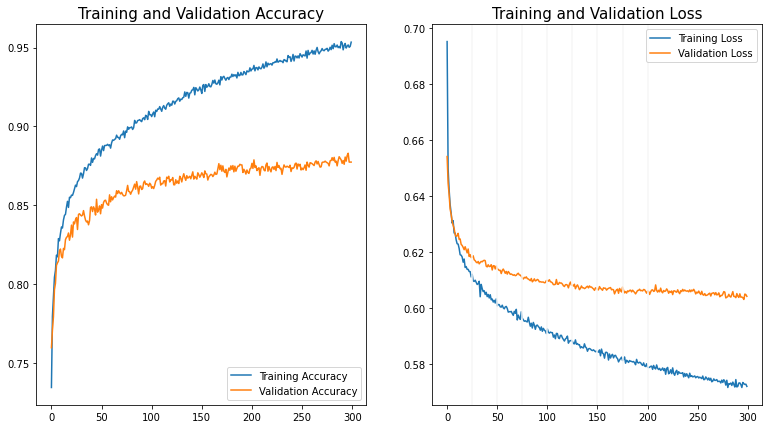



      The accuracy of classified MALIGNANT lesions is: 76.12%  and of classified BENIGN lesions is: 95.30%
-------------------------------------------------------------------------------------
 The FALSE NEGATIVES are: 446 and they represent 23.88% of the wrong classified MALIGNANT
 We change threshold with belief of  0.947 to be more precise of the correctly classified MALIGNANT
 FALSE NEGATIVES are now 19.97% which is 1.2 times more accurate than before
 This creates a 1.02% LOSS of the correctly classified BENIGN lesions(TNs)
 The original accuracy of the BENIGN was 95.30% and it became 93.30%
-------------------------------------------------------------------------------------



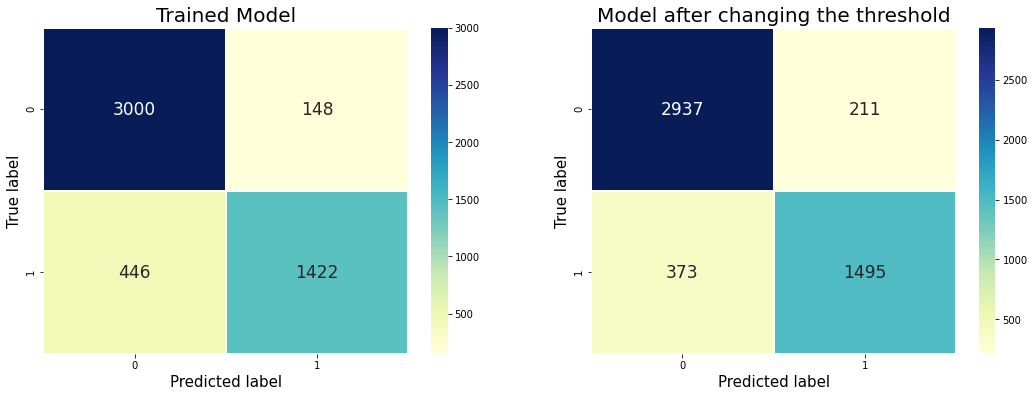

In [12]:
plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=15, ha='center')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
coord = [25, 50, 75, 100, 125, 150, 175, 200]
for line in coord:
    plt.axvline(x=line, color="#F6F6F6")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=15, ha='center')
plt.show()


CM = tf.math.confusion_matrix(val_data_gen.classes, y_pred) 
CM2 = tf.math.confusion_matrix(val_data_gen.classes, y2_pred)

plt.figure(figsize = (18,6))
plt.subplot(1,2,1)
plt.title('Trained Model', fontsize=20, ha='center')
sn.heatmap(CM, annot=True, fmt = "d", cmap="YlGnBu", linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)

plt.subplot(1,2,2)
plt.title('Model after changing the threshold', fontsize=20, ha='center')
sn.heatmap(CM2, annot=True, fmt = "d", cmap="YlGnBu", linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)


tn, fp, fn, tp = confusion_matrix(val_data_gen.classes, y_pred).ravel()
tn2, fp2, fn2, tp2 = confusion_matrix(val_data_gen.classes, y2_pred).ravel()

print("\n\n      The accuracy of classified MALIGNANT lesions is: {:.2f}%  and of classified BENIGN lesions is: {:.2f}%".format(
     (tp/val_mal)*100, (tn/val_ben)*100))
print("-------------------------------------------------------------------------------------")
print(" The FALSE NEGATIVES are: {} and they represent {:.2f}% of the wrong classified MALIGNANT".format(
     fn, (fn/val_mal)*100))
print(" We change threshold with belief of  {} to be more precise of the correctly classified MALIGNANT".format(belief))
print(" FALSE NEGATIVES are now {:.2f}% which is {:.1f} times more accurate than before".format(
     (fn2/val_mal)*100, (fn/val_mal)/(fn2/val_mal)))
print(" This creates a {:.2f}% LOSS of the correctly classified BENIGN lesions(TNs)".format((tn/tn2)))
print(" The original accuracy of the BENIGN was {:.2f}% and it became {:.2f}%".format(
     (tn/val_ben)*100, (tn2/val_ben)*100))
print("-------------------------------------------------------------------------------------\n")

### ROC curve and Predicted values

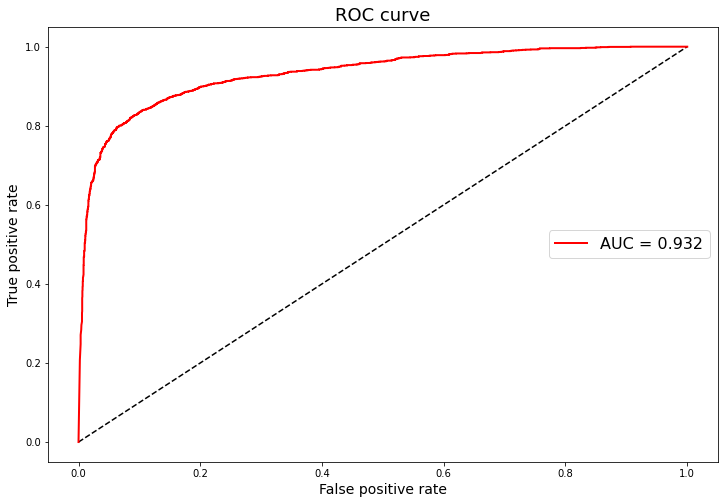

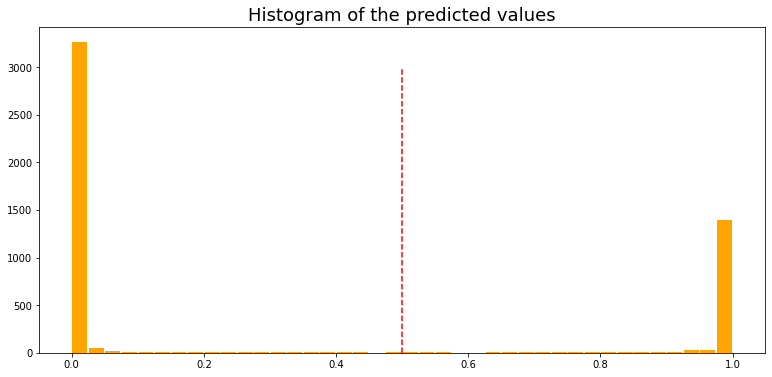

In [13]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_data_gen.classes, Y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, 'r-',label='AUC = {:.3f}'.format(auc_keras),linewidth=2)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC curve', fontsize=18)
plt.legend(loc='center right', prop={'size': 16})
plt.show()

# Histogram of the prediction values
plt.figure(figsize=(13,6))
plt.hist(Y_pred, bins=40, color="orange", rwidth=0.9)
plt.plot([0.5, 0.5], [0, 3000], "r--", linewidth=1.5)
plt.title('Histogram of the predicted values', fontsize=18)
plt.show()

# Part 2

### ########################################################


## Weight Before Training Impementation



### ########################################################

### Specify WBT Model

In [14]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

import efficientnet.tfkeras as efn

WBT_MODEL = efn.EfficientNetB0(input_shape=IMG_SHAPE,
                               include_top=False,
                               weights='imagenet') 

wbt_model_input = WBT_MODEL.input

add_layer = tf.keras.layers.GlobalAveragePooling2D()(WBT_MODEL.output)
#add_layer = tf.keras.constraints.MaxNorm(max_value=1, axis=0)(add_layer)
add_layer = tf.keras.layers.Dropout(0.5)(add_layer)
add_layer = tf.keras.layers.Dense(1, activation='sigmoid')(add_layer)

wbt_model = tf.keras.Model(wbt_model_input, add_layer)

#model.summary()

### Train WBT Model

In [15]:
# %%time

# class_weight = {0 : 1.0,
#                 1 : 32.0}

# wbt_model.compile(optimizer=tf.keras.optimizers.Adam(),
#                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                   metrics=['accuracy'])


# wbt_checkpoint_path = "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/wbt_checkpoints32/cp-{epoch}.ckpt"

# # Create a callback that saves the model's weights
# wbt_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=wbt_checkpoint_path,
#                                                      save_weights_only=True,
#                                                      verbose=1)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                   verbose=1,
#                                                   patience=40,   
#                                                   restore_best_weights=False)

# # Custom learning rate decay callback, CHANGE optimizer
# def wbt_lr_decay(epoch):  
#     if epoch < 8:
#         lr = 1e-5
#     elif epoch >= 8 and epoch < 48:
#         lr = 0.00001*tf.math.exp(0.02 * (8 - epoch))
#     else:
#         lr = 45e-7
       
#     tf.summary.scalar('learning rate', data=lr, step=epoch)    
#     return lr

# wbt_lr_callback = tf.keras.callbacks.LearningRateScheduler(wbt_lr_decay)


# # wbt_model = wbt_model
# # print(str(val_acc.index))
# # last_checkpoint = "./ISIC_TWO_CLASSES/Model/wbt_checkpoints/cp-1.ckpt"
# # print("\nContinues from checkpoint: {}\n".format(last_checkpoint))
# # wbt_model.load_weights(last_checkpoint)


# wbt_history = wbt_model.fit_generator(train_data_gen,                                               
#                                       steps_per_epoch=TOTAL_IMAGES // BATCH_SIZE,
#                                       epochs=WBT_EPOCHS,
#                                       validation_data=val_data_gen,
#                                       class_weight=class_weight,
#                                       validation_steps=TOTAL_VAL_IMAGES // BATCH_SIZE,
#                                       callbacks=[wbt_cp_callback, early_stopping, wbt_lr_callback]
#                                       )


# # Save model & history
# wbt_model.save("/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/WBT_Lesion_B0.h5")
# with open('/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/WBT_ModelHistory', 'wb') as h1_file:
#     pickle.dump(wbt_history.history, h1_file)
    
# print("\n--------------------")

### Load WBT history and make Predictions

In [16]:
##### Use current history or load from earlier training 
try:
    wbt_history
except NameError:
    print(">> Loading Wbt model")
    wbt_model = tf.keras.models.load_model('./ISIC_TWO_CLASSES/Model/WBT_Lesion_B0.h5')
    print(">> Loading latest model's History from the file\n")
    with open('ISIC_TWO_CLASSES/Model/WBT_ModelHistory', 'rb') as h2_file: 
        old_history = load(h2_file)
        history_stats = pd.DataFrame(old_history)
        print(history_stats.tail())
            
        acc4 = old_history['accuracy']
        val_acc4 = old_history['val_accuracy']
        loss4 = old_history['loss']
        val_loss4 = old_history['val_loss']
else:
    print("Using data from the trained Wbt model\n")
    history_stats = pd.DataFrame(wbt_history.history) 
    print(history_stats.tail())
    
    acc4 = wbt_history.history['accuracy']
    val_acc4 = wbt_history.history['val_accuracy']
    loss4 = wbt_history.history['loss']
    val_loss4 = wbt_history.history['val_loss']
    
# Save history to csv file
#history_stats.to_csv("./ISIC_TWO_CLASSES/Model/Wbt_EfB0_200_crop_32.csv", index=False)

# Gets index again in case of early stopping    
epochs_range = range(history_stats.index.stop)

# Find the weights with the best validation accuracy
# In case of early stopping ignore the latest x epochs, where x=12 
best_weight_wbt_model = wbt_model
if (history_stats.index.stop == WBT_EPOCHS):
    wbt_best_checkpoint = "./ISIC_TWO_CLASSES/Model/wbt_checkpoints32/cp-" + str(val_acc4.index(max(val_acc4))) +".ckpt"
    best_val_accuracy2 = val_acc4[val_acc4.index(max(val_acc4))]
else:
    wbt_best_checkpoint = "./ISIC_TWO_CLASSES/Model/wbt_checkpoints32/cp-" + str(val_acc4.index(max(val_acc4[:-39]))) +".ckpt"
    best_val_accuracy2 = val_acc4[val_acc4.index(max(val_acc4[:-39]))]
print("\nBest checkpoint at: {}".format(wbt_best_checkpoint))
print("With validation accuracy: {:.5f}\n".format(best_val_accuracy2))
best_weight_wbt_model.load_weights(wbt_best_checkpoint)


Y4_pred = best_weight_wbt_model.predict_generator(test_data_gen, steps=len(df_val), verbose=1)

y4_pred = []
for i in range(TOTAL_VAL_IMAGES): 
    if Y4_pred[i] >= 0.5:          
        y4_pred.append(1)
    else:
        y4_pred.append(0)

>> Loading Wbt model
>> Loading latest model's History from the file

         loss  accuracy  val_loss  val_accuracy        lr
195  4.341782  0.758038  0.662329      0.806310  0.000005
196  4.343663  0.766754  0.662341      0.805711  0.000005
197  4.324449  0.764858  0.659727      0.809704  0.000005
198  4.331232  0.767172  0.663923      0.803914  0.000005
199  4.350260  0.761229  0.663716      0.804712  0.000005

Best checkpoint at: ./ISIC_TWO_CLASSES/Model/wbt_checkpoints32/cp-188.ckpt
With validation accuracy: 0.81050

5016/5016 [==============================] - 69s 14ms/step


### Plots and Confusion matrix

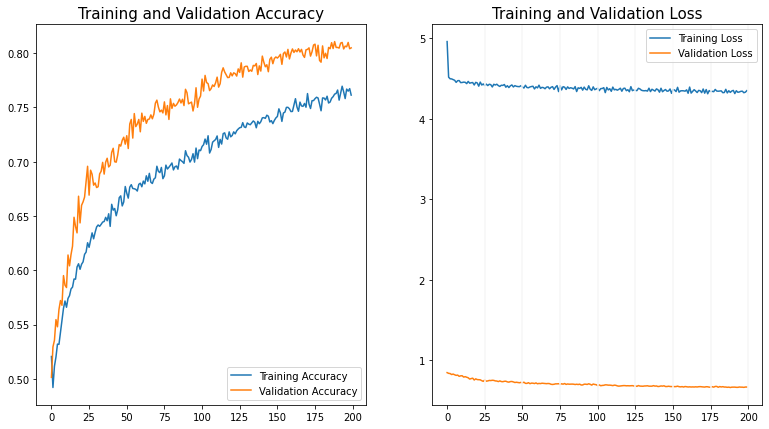

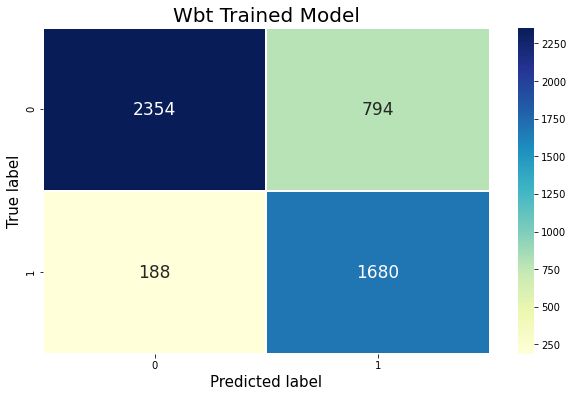

In [17]:
plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc4, label='Training Accuracy')
plt.plot(epochs_range, val_acc4, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=15, ha='center')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss4, label='Training Loss')
plt.plot(epochs_range, val_loss4, label='Validation Loss')
coord = [25, 50, 75, 100, 125, 150, 175, 200]
for line in coord:
    plt.axvline(x=line, color="#F6F6F6")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=15, ha='center')
plt.show()


CM4 = tf.math.confusion_matrix(val_data_gen.classes, y4_pred) 

plt.figure(figsize = (10,6))
plt.title('Wbt Trained Model', fontsize=20, ha='center')
sn.heatmap(CM4, annot=True, fmt = "d", cmap="YlGnBu", linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)

tn4, fp4, fn4, tp4 = confusion_matrix(val_data_gen.classes, y4_pred).ravel()

### ROC curve and Predicted values

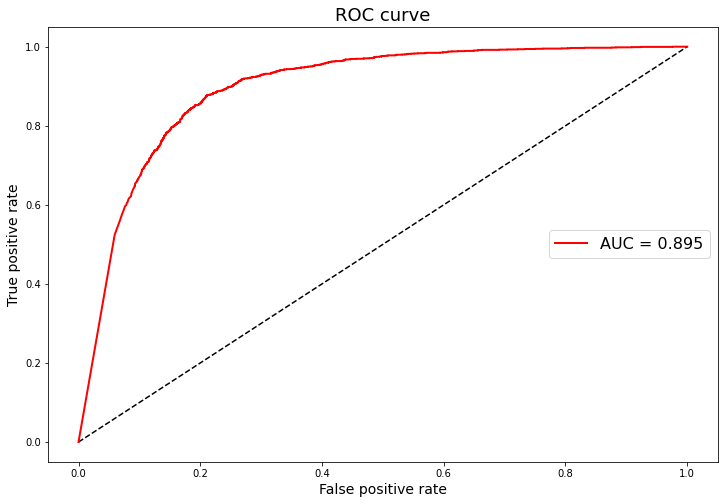

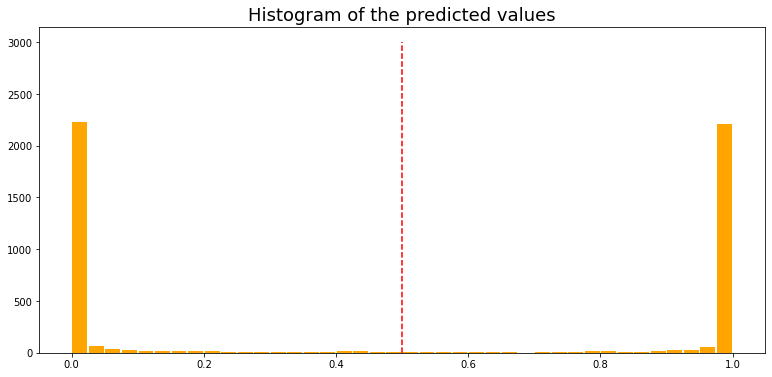

In [18]:
fpr_keras4, tpr_keras4, thresholds_keras4 = roc_curve(val_data_gen.classes, Y4_pred)
auc_keras4 = auc(fpr_keras4, tpr_keras4)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras4, tpr_keras4, 'r-',label='AUC = {:.3f}'.format(auc_keras4),linewidth=2)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC curve', fontsize=18)
plt.legend(loc='center right', prop={'size': 16})
plt.show()

# Histogram of the prediction values
plt.figure(figsize=(13,6))
plt.hist(Y4_pred, bins=40, color="orange", rwidth=0.9)
plt.plot([0.5, 0.5], [0, 3000], "r--", linewidth=1.5)
plt.title('Histogram of the predicted values', fontsize=18)
plt.show()

# Part 3

### ########################################################


## RWW crossentropy loss Impementation



### ########################################################

In [19]:
def create_rww_binary_crossentropy(fn_weight, fp_weight):    
    # fn_weight = 100, fp_weight=10 will penalize 10 times more the FN values than the FP ones
    # Like the treatment of having a binign malignant is 10 times more than 10 patients visiting the doctor 
    """
    binary_crossentropy is a special case of categorical_crossentropy.  
    The "all other" column is imputed. For single-label, an implementation is provided.
    However, this loss function is not very useful in a multi-label environment. 
    It only supports k=1. 

    We may also create a fully expressive loss function, which would require some
    efficient representation of a tensor of size (k, k, 2^k, 2^k)  
    """  
    def binary_loss_function(target, output):
        output = K.clip(output, K.epsilon(), 1 - K.epsilon()) 
    
        logs = K.log(output) # shape (m, 1)
        logs_1_sub = K.log(1-output) # shape (m, 1)

        return - K.mean(target * fn_weight * logs + 
                       (1-target) * fp_weight * logs_1_sub)

    return binary_loss_function

In [20]:
fn_weight, fp_weight = 320, 10     # wrong prediction of a FN is punished x times more 
rww_loss = create_rww_binary_crossentropy(fn_weight, fp_weight)  
print(rww_loss)

<function create_rww_binary_crossentropy.<locals>.binary_loss_function at 0x7fa9d6d36730>


### Specify RWW Model

In [21]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

import efficientnet.tfkeras as efn

RWW_MODEL = efn.EfficientNetB0(input_shape=IMG_SHAPE,
                                          include_top=False,
                                          weights='imagenet') 

rww_model_input = RWW_MODEL.input

add_layer = tf.keras.layers.GlobalAveragePooling2D()(RWW_MODEL.output)
add_layer = tf.keras.constraints.MaxNorm(max_value=1, axis=0)(add_layer)
add_layer = tf.keras.layers.Dropout(0.5)(add_layer)
add_pred = tf.keras.layers.Dense(1, activation='sigmoid')(add_layer)

rww_model = tf.keras.Model(rww_model_input, add_pred)

#rww_model.summary()

### Train RWW Model

In [22]:
# %%time


# rww_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.0, nesterov=False, name='SGD'), #tf.keras.optimizers.Adam(learning_rate=1e-5),                                                                                                          
#                   loss=rww_loss,                                                                                   #tf.keras.optimizers.Adam(), #"adam" lr=1e-5    
#                   metrics=['accuracy'])

# rww_checkpoint_path = "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/rww_checkpoints32/cp-{epoch}.ckpt"

# # Create a callback that saves the model's weights
# rww_cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=rww_checkpoint_path,
#                                                      save_weights_only=True,
#                                                      verbose=1,
#                                                      period=1)

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                   verbose=1,
#                                                   patience=40,  
#                                                   restore_best_weights=False)


# rww_history = rww_model.fit_generator(train_data_gen,                                               
#                                       steps_per_epoch=TOTAL_IMAGES // BATCH_SIZE,
#                                       epochs=RWW_EPOCHS,
#                                       validation_data=val_data_gen,
#                                       validation_steps=TOTAL_VAL_IMAGES // BATCH_SIZE,
#                                       callbacks=[rww_cp_callback, early_stopping]
#                                       )


# # Save model & history
# rww_model.save("/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/RWW_Lesion_B0.h5")
# with open('/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/RWW_ModelHistory', 'wb') as h2_file:
#     pickle.dump(rww_history.history, h2_file)
    
# print("\n--------------------")

### Load RWW history and make Predictions

In [23]:
##### Use current history or load from earlier training 
try:
    rww_history
except NameError:
    print(">> Loading Rww model")
    rww_model = tf.keras.models.load_model('./ISIC_TWO_CLASSES/Model/RWW_Lesion_B0.h5',
                                          custom_objects={'binary_loss_function': create_rww_binary_crossentropy(fn_weight,10)})
    print(">> Loading latest model's History from the file\n")
    with open('ISIC_TWO_CLASSES/Model/RWW_ModelHistory', 'rb') as h2_file: 
        old_history = load(h2_file)
        history_stats = pd.DataFrame(old_history)
        print(history_stats.tail())
            
        acc3 = old_history['accuracy']
        val_acc3 = old_history['val_accuracy']
        loss3 = old_history['loss']
        val_loss3 = old_history['val_loss']
else:
    print("Using data from the trained Rww model\n")
    history_stats = pd.DataFrame(rww_history.history) 
    print(history_stats.tail())
    
    acc3 = rww_history.history['accuracy']
    val_acc3 = rww_history.history['val_accuracy']
    loss3 = rww_history.history['loss']
    val_loss3 = rww_history.history['val_loss']
    
# Save history to csv file
#history_stats.to_csv("./ISIC_TWO_CLASSES/Model/Rww_EfB0_DR05_SGD_73_32.csv", index=False)

# Gets index again in case of early stopping    
epochs_range = range(history_stats.index.stop)

# Find the weights with the best validation accuracy
# In case of early stopping ignore the latest x epochs, where x=12 
best_weight_rww_model = rww_model
if (history_stats.index.stop == RWW_EPOCHS):
    rww_best_checkpoint = "./ISIC_TWO_CLASSES/Model/rww_checkpoints32/cp-" + str(val_acc3.index(max(val_acc3))) +".ckpt"
    best_val_accuracy3 = val_acc3[val_acc3.index(max(val_acc3))]
else:
    rww_best_checkpoint = "./ISIC_TWO_CLASSES/Model/rww_checkpoints32/cp-" + str(val_acc3.index(max(val_acc3[:-39]))) +".ckpt"
    best_val_accuracy3 = val_acc3[val_acc3.index(max(val_acc3[:-39]))]
print("\nBest checkpoint at: {}".format(rww_best_checkpoint))
print("With validation accuracy: {:.5f}\n".format(best_val_accuracy3))
best_weight_rww_model.load_weights(rww_best_checkpoint)


Y3_pred = best_weight_rww_model.predict_generator(test_data_gen, steps=len(df_val), verbose=1)

y3_pred = []
for i in range(TOTAL_VAL_IMAGES):
    if Y3_pred[i] >= 0.5: 
        y3_pred.append(1)
    else:
        y3_pred.append(0)

>> Loading Rww model
>> Loading latest model's History from the file

         loss  accuracy   val_loss  val_accuracy
68  10.028614  0.737713  26.715736      0.791334
69  10.333815  0.733067  26.086456      0.779353
70  10.167215  0.738093  24.740583      0.769569
71  10.012805  0.738692  23.416296      0.776358
72   9.847539  0.744535  25.931656      0.782947

Best checkpoint at: ./ISIC_TWO_CLASSES/Model/rww_checkpoints32/cp-33.ckpt
With validation accuracy: 0.67093

5016/5016 [==============================] - 68s 14ms/step


### Plots and Confusion matrix

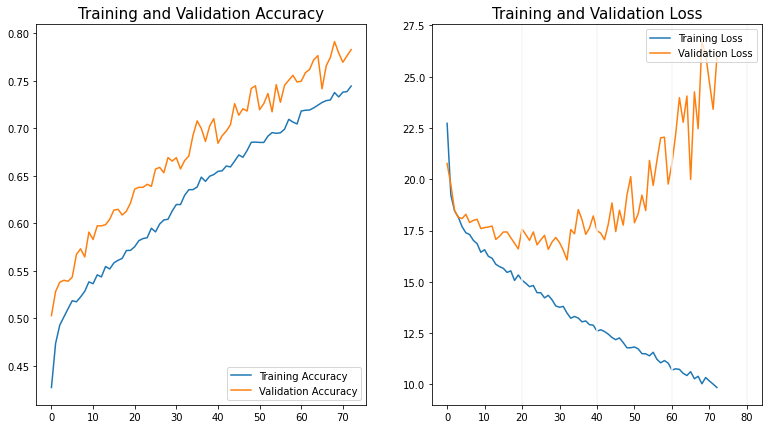

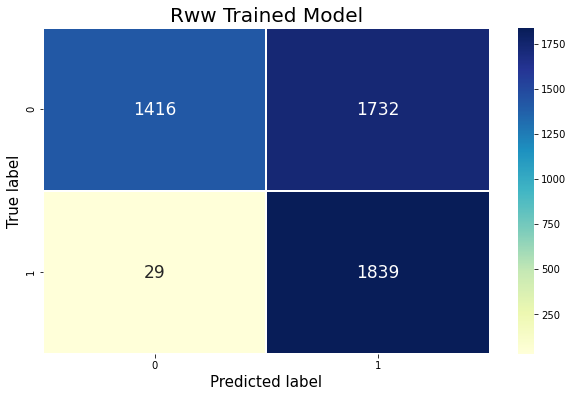

In [24]:
plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc3, label='Training Accuracy')
plt.plot(epochs_range, val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy', fontsize=15, ha='center')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Training Loss')
plt.plot(epochs_range, val_loss3, label='Validation Loss')
coord = [20, 40, 60, 80]
for line in coord:
    plt.axvline(x=line, color="#F6F6F6")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontsize=15, ha='center')
plt.show()


CM3 = tf.math.confusion_matrix(val_data_gen.classes, y3_pred) 

plt.figure(figsize = (10,6))
plt.title('Rww Trained Model', fontsize=20, ha='center')
sn.heatmap(CM3, annot=True, fmt = "d", cmap="YlGnBu", linewidths=1, annot_kws={"fontsize":17})
plt.xlabel('Predicted label', fontsize=15)
plt.ylabel('True label', fontsize=15)

tn3, fp3, fn3, tp3 = confusion_matrix(val_data_gen.classes, y3_pred).ravel()

### ROC curve and Predicted values

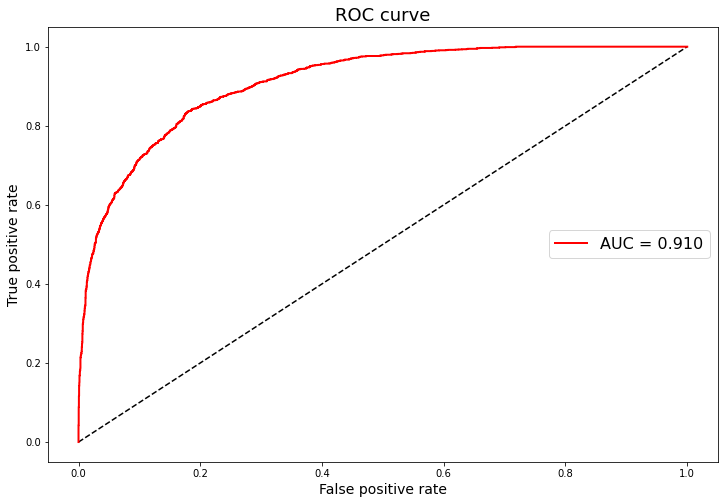

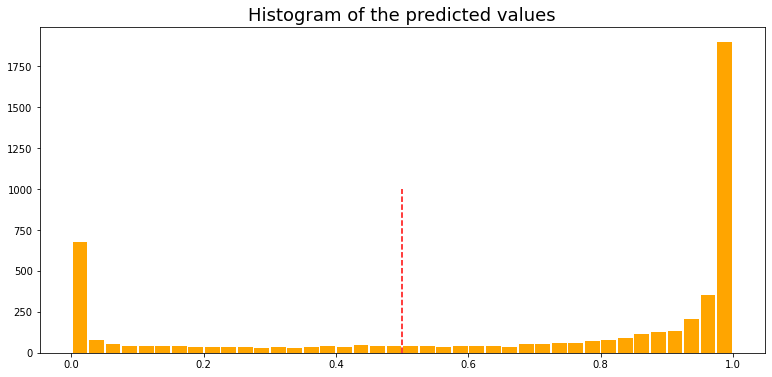

In [25]:
fpr_keras3, tpr_keras3, thresholds_keras3 = roc_curve(val_data_gen.classes, Y3_pred)
auc_keras3 = auc(fpr_keras3, tpr_keras3)

plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras3, tpr_keras3, 'r-',label='AUC = {:.3f}'.format(auc_keras3),linewidth=2)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC curve', fontsize=18)
plt.legend(loc='center right', prop={'size': 16})
plt.show()

# Histogram of the prediction values
plt.figure(figsize=(13,6))
plt.hist(Y3_pred, bins=40, color="orange", rwidth=0.9)
plt.plot([0.5, 0.5], [0, 1000], "r--", linewidth=1.5)
plt.title('Histogram of the predicted values', fontsize=18)
plt.show()

## Make comparisons between the two approaches

In [26]:
# Threshold approach
print("-------------------------------------------------------------------------------------------------------")
print(" Simple Model        >> FALSE NEGATIVES: {} and they represent {:.2f}% of the wrong classified MALIGNANT lesions".format(
     fn, (fn/val_mal)*100))
print(" Threshold Approach  >> FALSE NEGATIVES: {} and they represent {:.2f}%, which is {:.1f} times more accurate \
      ".format(fn2, (fn2/val_mal)*100, (fn/val_mal)/(fn2/val_mal)))
print("                        LOSS: {:.2f}% of the correctly classified BENIGN lesions(TNs)".format((tn/tn2)))
# WBT approach
print(" WBT Model           >> FALSE NEGATIVES: {} and they represent {:.2f}% of the wrong classified MALIGNANT lesions".format(
     fn4, (fn4/val_mal)*100))
# RWW approach
print(" RWW Model           >> FALSE NEGATIVES: {} and they represent {:.2f}% of the wrong classified MALIGNANT lesions".format(
     fn3, (fn3/val_mal)*100))
print("-------------------------------------------------------------------------------------------------------\n")
print("\033[1m Stats of the Validation Accuracy can also be seen\n at the SENSITIVITY and SPECIFICITY rows:\033[0m")

# Functions for statistics and visualization
def sensitivity(tp, fn):
    output = str(round(tp / (tp + fn), 3))
    return output

def specificity(tn, fp):
    output = str(round(tn / (tn + fp), 3))
    return output

def f1_score(tp, fp, fn):
    output = str(round(2*tp / (2*tp + fp + fn), 3))
    return output

# Expected Fb-meassure
# Fn_weight_over_fp must be a POSITIVE integer.
def fb_score(Fn_over_fp, FN, TP, FP, TN):
    if Fn_over_fp == 0:
        b = 1
    else:
        b = (1/(2*Fn_over_fp))
    output = (b/specificity(TN, FP) + (1-b)/sensitivity(TP, FN))**-1
    return output

def real_cost(factor, fp, fn):
    output = factor*fn + fp
    return output

# DataFrame Styling
def row_color(s, axis=1):
    col = []
    for i in range(len(data['Simple Model'])):
        if (i==2 or i ==4 or i==8 ):
            col.append('background-color: #2D2926')
        elif (i==3 or i==5):
            col.append('background-color: #F2AA4C')
        else:
            col.append('background-color: #DDC6B6')
    return col

def text_color(s, axis=1):
    tcol = []
    for i in range(len(data['Simple Model'])):
        if(i==2 or i ==4 or i==8):
            tcol.append('color: #E94B3C')
        elif(i==3 or i==5):
            tcol.append('color: #101820')
        else:
            tcol.append('color: #262223')
    return tcol

# DataFrame for each class accuracy
data1 = {'Malignant': [str(round((tp/val_mal)*100, 1))+'%', str(round((tp2/val_mal)*100, 1))+'%',
                  str(round((tp4/val_mal)*100, 1))+'%',str(round((tp3/val_mal)*100, 1))+'%'],
         'Benign': [str(round((tn/val_ben)*100, 1))+'%', str(round((tn2/val_ben)*100, 1))+'%',
                  str(round((tn4/val_ben)*100, 1))+'%',str(round((tn3/val_ben)*100, 1))+'%']
        }
df1 = pd.DataFrame(data1, columns = ['Malignant', 'Benign'],
                  index=['Simple Model','Threshold= '+str(-belief),'WBT Model','RWW Model'])
df1.columns = pd.MultiIndex.from_tuples(zip(['Val_Accuracy  ', ''], df1.columns))

# DataFrame for Statistics
data = {'Simple Model': [ str(round(acc[155], 3)), str(round(best_val_accuracy1, 3)), fn, str(round(fn/val_mal, 3)),
                     tn, specificity(tn, fp), sensitivity(tp, fn), f1_score(tp, fp, fn), real_cost(8, fp, fn)],
        'Threshold= '+str(-belief): ['-', '-', fn2, str(round(fn2/val_mal, 3)),
                      tn2, specificity(tn2, fp2), sensitivity(tp2, fn2), f1_score(tp2, fp2, fn2), real_cost(8, fp2, fn2)],
        'WBT Model': [ str(round(acc4[-39], 3)), str(round(best_val_accuracy2, 3)), fn4, str(round(fn4/val_mal, 3)),
                     tn4, specificity(tn4, fp4), sensitivity(tp4, fn4), f1_score(tp4, fp4, fn4), real_cost(8, fp4, fn4)],
        'RWW Model': [ str(round(acc3[-39], 3)), str(round(best_val_accuracy3, 3)), fn3, str(round(fn3/val_mal, 3)),
                      tn3, specificity(tn3, fp3), sensitivity(tp3, fn3), f1_score(tp3, fp3, fn3), real_cost(8, fp3, fn3)]
        }

df2 = pd.DataFrame(data, columns = ['Simple Model', 'Threshold= '+str(-belief), 'WBT Model','RWW Model'],
                  index=['Accuracy','Val_Accuracy','FN','1 - Sensitivity','TN', 'Specificity','Sensitivity','F1 score','Real Cost (FN/FP = 32)'])

# Apply styling
df1 = df1.style.set_table_attributes('style="font-size: 20px; \
                                           border: 1.3px solid #000; \
                                           background-color: #E9E3D6;"')

df2 = df2.style.set_table_attributes('style="font-size: 22px; \
                                           border: 1.3px solid #000; \
                                           background-color: #E9E3D6";')
df2 = df2.set_properties(**{
    'text-align': 'center',
    'font-size': '14pt',
    'border': '1.3px solid #000'
})

display(df1)
display(df2.apply(row_color).apply(text_color))

-------------------------------------------------------------------------------------------------------
 Simple Model        >> FALSE NEGATIVES: 446 and they represent 23.88% of the wrong classified MALIGNANT lesions
 Threshold Approach  >> FALSE NEGATIVES: 373 and they represent 19.97%, which is 1.2 times more accurate       
                        LOSS: 1.02% of the correctly classified BENIGN lesions(TNs)
 WBT Model           >> FALSE NEGATIVES: 188 and they represent 10.06% of the wrong classified MALIGNANT lesions
 RWW Model           >> FALSE NEGATIVES: 29 and they represent 1.55% of the wrong classified MALIGNANT lesions
-------------------------------------------------------------------------------------------------------

 Stats of the Validation Accuracy can also be seen
 at the SENSITIVITY and SPECIFICITY rows:


,Val_Accuracy,
,Malignant,Benign
Simple Model,76.1%,95.3%
Threshold= -0.947,80.0%,93.3%
WBT Model,89.9%,74.8%
RWW Model,98.4%,45.0%


,Simple Model,Threshold= -0.947,WBT Model,RWW Model
Accuracy,0.925,-,0.752,0.636
Val_Accuracy,0.883,-,0.811,0.671
FN,446,373,188,29
1 - Sensitivity,0.239,0.2,0.101,0.016
TN,3000,2937,2354,1416
Specificity,0.953,0.933,0.748,0.45
Sensitivity,0.761,0.8,0.899,0.984
F1 score,0.827,0.837,0.774,0.676
Real Cost (FN/FP = 32),3716,3195,2298,1964


### ROC curves

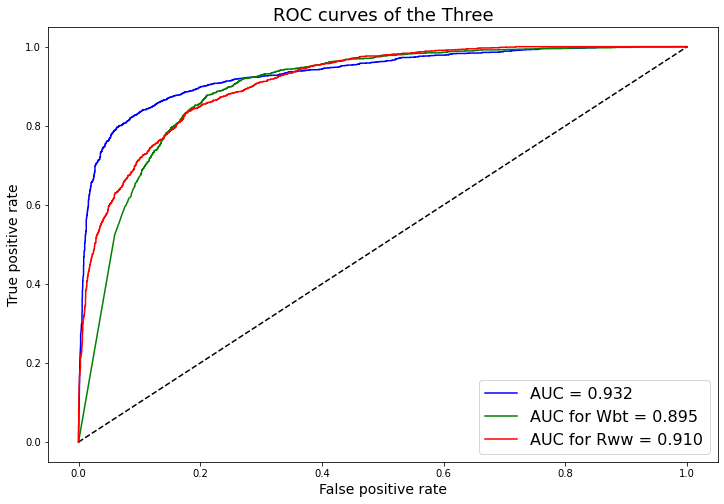

In [27]:
plt.figure(figsize=(12, 8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, 'b-',label='AUC = {:.3f}'.format(auc_keras),linewidth=1.5)
plt.plot(fpr_keras4, tpr_keras4, 'g-',label='AUC for Wbt = {:.3f}'.format(auc_keras4),linewidth=1.5)
plt.plot(fpr_keras3, tpr_keras3, 'r-',label='AUC for Rww = {:.3f}'.format(auc_keras3),linewidth=1.5)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('ROC curves of the Three', fontsize=18)
plt.legend(loc='lower right', prop={'size': 16})
plt.show()

### Different Weights & Correlation of Statistics

,Model Accuracy,AUC,F1 score,Fb measure,Sensitivity,Specificity,FN / FP,Real Cost
WBT - 2,0.880,0.933,0.827,0.812,0.778,0.939,415 / 191,1021
RWW - 2,0.851,0.922,0.801,0.832,0.823,0.862,330 / 434,1094
WBT - 4,0.876,0.929,0.824,0.818,0.806,0.911,363 / 281,1733
RWW - 4,0.836,0.923,0.783,0.882,0.903,0.760,181 / 756,1480
WBT - 8,0.858,0.918,0.806,0.818,0.814,0.877,346 / 385,3153
RWW - 8,0.814,0.922,0.753,0.915,0.938,0.671,115 / 1036,1956
WBT - 16,0.849,0.911,0.803,0.848,0.849,0.842,282 / 498,5010
RWW - 16,0.783,0.921,0.721,0.947,0.967,0.577,62 / 1333,2325
WBT - 32,0.811,0.910,0.774,0.896,0.899,0.748,188 / 794,6810
RWW - 32,0.671,0.910,0.676,0.966,0.984,0.450,29 / 1732,2660


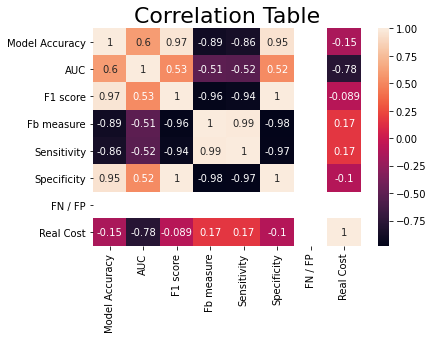

In [28]:
def row_color2(s, axis=0):
    col = []
    for i in range(len(data['Real Cost'])):
        if (i==0 or i==3 or i==5 or i==7 or i==9):
            col.append('background-color: #67D27C')
        else:
            col.append('background-color: #ACE2B7')
    return col

def column_color(s):
    if s=="1021" or s=="1480" or s=="1956" or s=="2325" or s=="2660":
        color = "#FF9933"
    else:
        color = '#FFCC99' 
    return 'background-color: %s' % color

# DataFrame for Statistics
Accuracies = ['0.880','0.851','0.876','0.836','0.858','0.814','0.849','0.783','0.811','0.671']
Auc = ['0.933','0.922','0.929','0.923','0.918','0.922','0.911','0.921','0.910','0.910']
F1score = ['0.827', '0.801','0.824','0.783','0.806','0.753','0.803','0.721','0.774','0.676']
Fbmeasure = ['0.812', '0.832','0.818','0.882','0.818','0.915','0.848','0.947','0.896','0.966']
Sens = ['0.778', '0.823','0.806','0.903','0.814','0.938','0.849','0.967','0.899','0.984']
Spec = ['0.939', '0.862','0.911','0.760','0.877','0.671','0.842','0.577','0.748','0.450']
FnFp = [ '415 / 191', '330 / 434', '363 / 281', '181 / 756', '346 / 385', '115 / 1036', '282 / 498', '62 / 1333','188 / 794','29 / 1732']
Cost = [ '1021','1094','1733','1480','3153','1956','5010','2325','6810','2660']


data = {'Model Accuracy': Accuracies ,
        'AUC' : Auc,
        'F1 score': F1score,
        'Fb measure': Fbmeasure,
        'Sensitivity': Sens,
        'Specificity': Spec,
        'FN / FP': FnFp,
        'Real Cost': Cost
        }

df3 = pd.DataFrame(data, columns = ['Model Accuracy', 'AUC', 'F1 score', 'Fb measure', 'Sensitivity', 'Specificity', 'FN / FP','Real Cost'],
                  index=['WBT - 2','RWW - 2','WBT - 4','RWW - 4','WBT - 8','RWW - 8','WBT - 16','RWW - 16','WBT - 32','RWW - 32'])

df3 = df3.style.set_table_attributes('style="font-size: 18px; \
                                           border: 1.3px solid #000; \
                                           background-color: #E9E3D6;"')
df3 = df3.set_properties(**{
    'text-align': 'center',
    'font-size': '14pt',
    'border': '1px solid #000'
})

df3.apply(row_color2)
df3.applymap(column_color, subset=pd.IndexSlice[:, ['Real Cost']])
display(df3)

# Correlation Matrix
Correl0 = {'Model Accuracy': Accuracies ,
        'AUC' : Auc,
        'F1 score': F1score,
        'Fb measure': Fbmeasure,
        'Sensitivity': Sens,
        'Specificity': Spec,
        'Real Cost': Cost
        }

df4 = pd.DataFrame(Correl0, columns = ['Model Accuracy', 'AUC', 'F1 score', 'Fb measure', 'Sensitivity', 'Specificity', 'FN / FP','Real Cost'])
corrMatrix = df4.astype(float).corr()
sn.heatmap(corrMatrix, annot=True)
plt.rcParams["figure.figsize"] = (12,8)
plt.title('Correlation Table', fontsize=22)
plt.show()

### Plots of Different Weight Statistics

----------------------------------------------------------------------------------------------
 Both Accuracies and F1scores slightly following the graph of the Cost, but they gradually 
 dropping as the weights get higher. This happens due to RWW always achieves less accuracy 
 than the WBT model, because it overfits if it can not improve its trade-off
----------------------------------------------------------------------------------------------
 There is also a correlation between the Sensitivity/Recall of the Model and the Cost
 This again makes sense cause the higher the number of Sensitivity achieved - the Lower
 the FNs are, therefore the penalize is small and that leads to a Lower Cost
----------------------------------------------------------------------------------------------



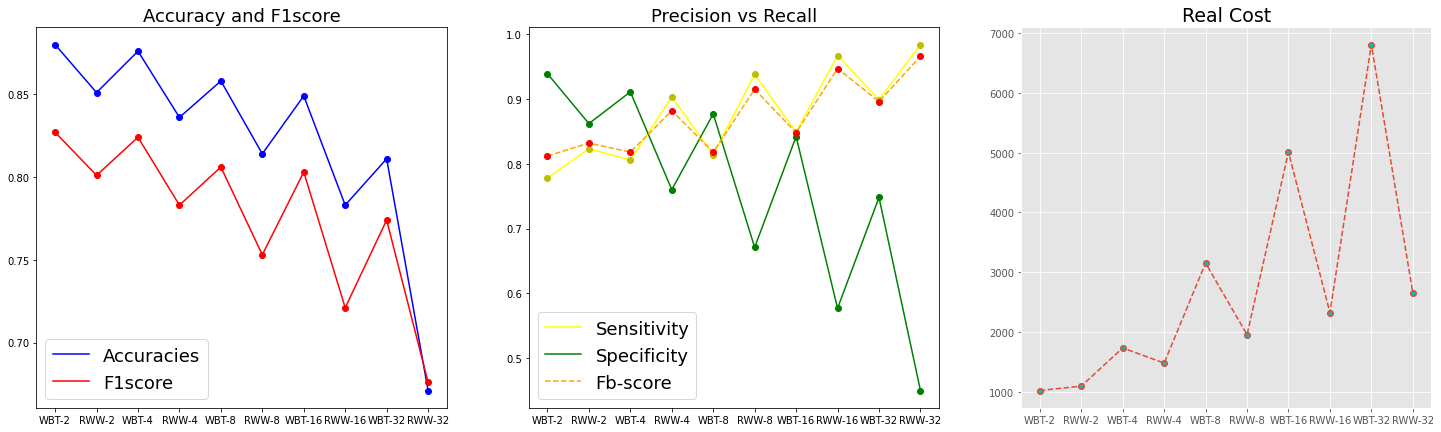

In [29]:
Accuracies = [0.880, 0.851, 0.876, 0.836, 0.858, 0.814, 0.849, 0.783, 0.811, 0.671]
Auc = [0.933, 0.922, 0.929, 0.923, 0.918, 0.922, 0.911, 0.921, 0.910, 0.910]
F1score = [0.827, 0.801, 0.824, 0.783, 0.806, 0.753, 0.803, 0.721, 0.774, 0.676]
Fbmeasure = [0.812, 0.832, 0.818, 0.882, 0.818, 0.915, 0.848, 0.947, 0.896, 0.966]
Sens = [0.778, 0.823, 0.806, 0.903, 0.814, 0.938, 0.849, 0.967, 0.899, 0.984]
Spec = [0.939, 0.862, 0.911, 0.760, 0.877, 0.671, 0.842, 0.577, 0.748, 0.450]
Fn = [415, 330, 363, 181, 346, 115, 282, 62, 188, 29]
Cost = [1021, 1094, 1733, 1480, 3153, 1956, 5010, 2325, 6810, 2660]

plt.figure(figsize=(25, 7))
plt.subplot(1, 3, 1)
plt.plot(Accuracies, label='Accuracies', color="blue")
plt.plot(Accuracies, 'bo')
plt.plot(F1score, label='F1score', color="red")
plt.plot(F1score, 'ro')
plt.xticks(np.arange(10), ['WBT-2', 'RWW-2', 'WBT-4', 'RWW-4', 'WBT-8', 'RWW-8', 'WBT-16', 'RWW-16', 'WBT-32', 'RWW-32'])
plt.legend(loc='lower left', fontsize='18')
plt.title('Accuracy and F1score', color="black", fontsize=18, ha='center')

plt.subplot(1, 3, 2)
plt.plot(Sens, label='Sensitivity', color="yellow")
plt.plot(Sens, 'yo')
plt.plot(Spec, label='Specificity', color="green")
plt.plot(Spec, 'go')
plt.plot(Fbmeasure, '--',label='Fb-score', color="orange")
plt.plot(Fbmeasure, 'ro')
plt.xticks(np.arange(10), ['WBT-2', 'RWW-2', 'WBT-4', 'RWW-4', 'WBT-8', 'RWW-8', 'WBT-16', 'RWW-16', 'WBT-32', 'RWW-32'])
plt.legend(loc='lower left', fontsize='18')
plt.title('Precision vs Recall', color="black", fontsize=18, ha='center')

the_style = 'ggplot'
plt.style.use([the_style])
plt.subplot(1, 3, 3)
with plt.style.context(the_style):
    plt.plot(Cost,'o--', label='Cost')
    plt.plot(Cost, 'c.',label='Cost')
    plt.title('Real Cost', color="black", fontsize=19, ha='center')
    plt.xticks(np.arange(10), ['WBT-2', 'RWW-2', 'WBT-4', 'RWW-4', 'WBT-8', 'RWW-8', 'WBT-16', 'RWW-16', 'WBT-32', 'RWW-32'])

print("----------------------------------------------------------------------------------------------")
print(" Both Accuracies and F1scores slightly following the graph of the Cost, but they gradually ")
print(" dropping as the weights get higher. This happens due to RWW always achieves less accuracy ")
print(" than the WBT model, because it overfits if it can not improve its trade-off")
print("----------------------------------------------------------------------------------------------")
print(" There is also a correlation between the Sensitivity/Recall of the Model and the Cost")
print(" This again makes sense cause the higher the number of Sensitivity achieved - the Lower")
print(" the FNs are, therefore the penalize is small and that leads to a Lower Cost")
print("----------------------------------------------------------------------------------------------\n")

### Load All Model Statistics and Make Predictions

In [30]:
csvs = ["/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/Wbt_EfB0_200_crop_2.csv",
        "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/Wbt_EfB0_200_crop_4.csv",
        "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/Wbt_EfB0_200_crop_8.csv",
        "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/Wbt_EfB0_200_crop_16.csv",
        "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/Wbt_EfB0_200_crop_32.csv",
        "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/Rww_EfB0_DR05_SGD_157_2.csv",
        "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/Rww_EfB0_DR05_SGD_141_4.csv",
        "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/Rww_EfB0_DR05_SGD_116_8.csv",
        "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/Rww_EfB0_DR05_SGD_99_16.csv",
        "/home/vasileiosaidonis/ISIC_TWO_CLASSES/Model/Rww_EfB0_DR05_SGD_73_32.csv"]

checks = ["./ISIC_TWO_CLASSES/Model/wbt_checkpoints2/cp-",
          "./ISIC_TWO_CLASSES/Model/wbt_checkpoints4/cp-",
          "./ISIC_TWO_CLASSES/Model/wbt_checkpoints8/cp-",
          "./ISIC_TWO_CLASSES/Model/wbt_checkpoints16/cp-",
          "./ISIC_TWO_CLASSES/Model/wbt_checkpoints32/cp-",
          "./ISIC_TWO_CLASSES/Model/rww_checkpoints2/cp-",
          "./ISIC_TWO_CLASSES/Model/rww_checkpoints4/cp-",
          "./ISIC_TWO_CLASSES/Model/rww_checkpoints8/cp-",
          "./ISIC_TWO_CLASSES/Model/rww_checkpoints16/cp-",
          "./ISIC_TWO_CLASSES/Model/rww_checkpoints32/cp-"]

value1, value2, value3, value4, value5 = None, None, None, None, None
value6, value7, value8, value9, value10 = None, None, None, None, None
FPR_keras = [value1, value2, value3, value4, value5, value6, value7, value8, value9, value10]
TPR_keras = FPR_keras.copy()
AUC_keras = FPR_keras.copy()

for i in range(len(csvs)):
    data = pd.read_csv(csvs[i]) 

    acc0 = data["accuracy"]
    val_acc0 = data["val_accuracy"]
    loss0 = data["loss"]
    val_loss0 = data["val_loss"]

    print("\n>> Prediction {}/{}".format(i+1, len(csvs)))
    # ##LOAD BEST for RWW or WBT && make PREDICTIONS
    if i < 5:
        best_weight_wbt_model = wbt_model
        max_index, max_value = max(enumerate(val_acc0), key=operator.itemgetter(1))
        wbt_best_checkpoint = checks[i] + str(max_index) +".ckpt"
        print("\nBest checkpoint at: {}".format(wbt_best_checkpoint))
        print("With validation accuracy: {:.5f}\n".format(max_value))
        best_weight_wbt_model.load_weights(wbt_best_checkpoint)
        
        Yx_pred = best_weight_wbt_model.predict_generator(test_data_gen, steps=5016, verbose=1)
    else:
        best_weight_rww_model = rww_model
        max_index, max_value = max(enumerate(val_acc0[:-39]), key=operator.itemgetter(1))
        rww_best_checkpoint = checks[i] + str(max_index) +".ckpt"
        print("\nBest checkpoint at: {}".format(rww_best_checkpoint))
        print("With validation accuracy: {:.5f}\n".format(max_value))
        best_weight_rww_model.load_weights(rww_best_checkpoint)
        
        Yx_pred = best_weight_rww_model.predict_generator(test_data_gen, steps=5016, verbose=1)

    # ##STORE VALUES
    FPR_keras[i], TPR_keras[i], thresholds_kerasX = roc_curve(val_data_gen.classes, Yx_pred)
    AUC_keras[i] = auc(FPR_keras[i], TPR_keras[i])


>> Prediction 1/10

Best checkpoint at: ./ISIC_TWO_CLASSES/Model/wbt_checkpoints2/cp-187.ckpt
With validation accuracy: 0.88019

5016/5016 [==============================] - 69s 14ms/step

>> Prediction 2/10

Best checkpoint at: ./ISIC_TWO_CLASSES/Model/wbt_checkpoints4/cp-188.ckpt
With validation accuracy: 0.87560

5016/5016 [==============================] - 69s 14ms/step

>> Prediction 3/10

Best checkpoint at: ./ISIC_TWO_CLASSES/Model/wbt_checkpoints8/cp-197.ckpt
With validation accuracy: 0.85803

5016/5016 [==============================] - 69s 14ms/step

>> Prediction 4/10

Best checkpoint at: ./ISIC_TWO_CLASSES/Model/wbt_checkpoints16/cp-195.ckpt
With validation accuracy: 0.84924

5016/5016 [==============================] - 69s 14ms/step

>> Prediction 5/10

Best checkpoint at: ./ISIC_TWO_CLASSES/Model/wbt_checkpoints32/cp-188.ckpt
With validation accuracy: 0.81050

5016/5016 [==============================] - 69s 14ms/step

>> Prediction 6/10

Best checkpoint at: ./ISIC_TWO_C

### ROC curves of all Different Weights and Comparisons

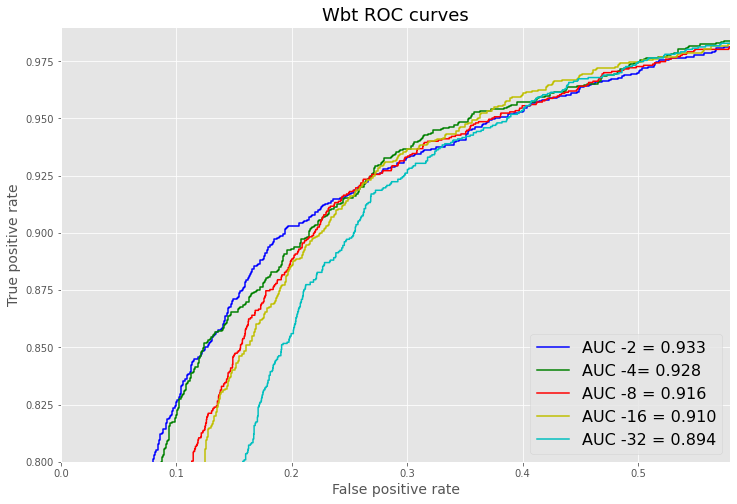

In [31]:
plt.figure(figsize=(12, 8))
plt.xlim(0, 0.58)
plt.ylim(0.8, 0.99)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(FPR_keras[0], TPR_keras[0], 'b-',label='AUC -2 = {:.3f}'.format(AUC_keras[0]), linewidth=1.5)
plt.plot(FPR_keras[1], TPR_keras[1], 'g-',label='AUC -4= {:.3f}'.format(AUC_keras[1]), linewidth=1.5)
plt.plot(FPR_keras[2], TPR_keras[2], 'r-',label='AUC -8 = {:.3f}'.format(AUC_keras[2]), linewidth=1.5)
plt.plot(FPR_keras[3], TPR_keras[3], 'y-',label='AUC -16 = {:.3f}'.format(AUC_keras[3]), linewidth=1.5)
plt.plot(FPR_keras[4], TPR_keras[4], 'c-',label='AUC -32 = {:.3f}'.format(AUC_keras[4]), linewidth=1.5)
###
###
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('Wbt ROC curves', fontsize=18)
plt.legend(loc='lower right', prop={'size': 16})
plt.show()

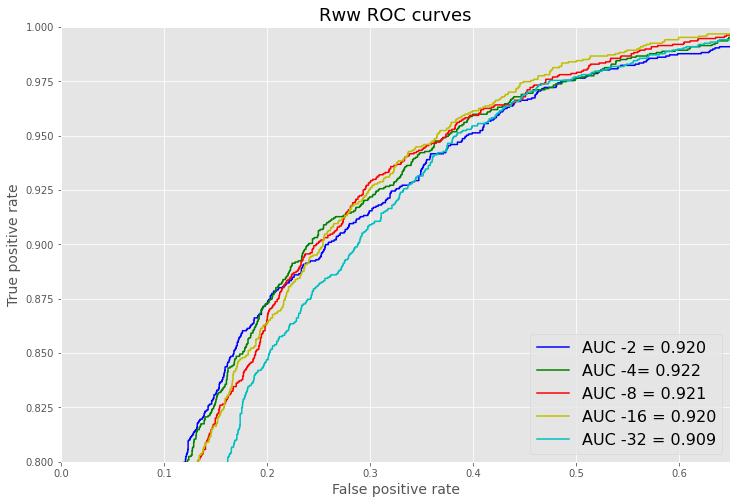

In [32]:
plt.figure(figsize=(12, 8))
plt.xlim(0, 0.65)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(FPR_keras[5], TPR_keras[5], 'b-',label='AUC -2 = {:.3f}'.format(AUC_keras[5]), linewidth=1.5)
plt.plot(FPR_keras[6], TPR_keras[6], 'g-',label='AUC -4= {:.3f}'.format(AUC_keras[6]), linewidth=1.5)
plt.plot(FPR_keras[7], TPR_keras[7], 'r-',label='AUC -8 = {:.3f}'.format(AUC_keras[7]), linewidth=1.5)
plt.plot(FPR_keras[8], TPR_keras[8], 'y-',label='AUC -16 = {:.3f}'.format(AUC_keras[8]), linewidth=1.5)
plt.plot(FPR_keras[9], TPR_keras[9], 'c-',label='AUC -32 = {:.3f}'.format(AUC_keras[9]), linewidth=1.5)
plt.xlabel('False positive rate', fontsize=14)
plt.ylabel('True positive rate', fontsize=14)
plt.title('Rww ROC curves', fontsize=18)
plt.legend(loc='lower right', prop={'size': 16})
plt.show()